In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
stop = stopwords.words('english')

pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("/Users/jamesfung/repos/side_projects/debt_relief/listings.csv")

In [3]:
data.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews,reviews_per_month,price
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,2,288,46,0.39,225
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,3,1,365,0,NaN,150
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,1,1,212,274,4.64,89
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,10,1,0,9,0.10,80
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,3,1,127,75,0.60,200
5,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,45,1,0,49,0.39,60
6,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,2,1,239,434,3.48,79
7,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,2,1,0,118,0.98,79
8,5222,Best Hideaway,7516,Marilyn,Manhattan,East Village,40.72764,-73.97949,Entire home/apt,30,1,322,94,0.74,116
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,1,4,0,161,1.33,150


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48864 entries, 0 to 48863
Data columns (total 15 columns):
id                                48864 non-null int64
name                              48848 non-null object
host_id                           48864 non-null int64
host_name                         48846 non-null object
neighbourhood_group               48864 non-null object
neighbourhood                     48864 non-null object
latitude                          48864 non-null float64
longitude                         48864 non-null float64
room_type                         48864 non-null object
minimum_nights                    48864 non-null int64
calculated_host_listings_count    48864 non-null int64
availability_365                  48864 non-null int64
number_of_reviews                 48864 non-null int64
reviews_per_month                 38733 non-null float64
price                             48864 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 5

In [5]:
#Drop some unecessary columns
data = data.drop(['id'],axis=1)

In [6]:
data

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews,reviews_per_month,price
0,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,2,288,46,0.39,225
1,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,3,1,365,0,NaN,150
2,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,1,1,212,274,4.64,89
3,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,10,1,0,9,0.10,80
4,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,3,1,127,75,0.60,200
5,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,45,1,0,49,0.39,60
6,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,2,1,239,434,3.48,79
7,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,2,1,0,118,0.98,79
8,Best Hideaway,7516,Marilyn,Manhattan,East Village,40.72764,-73.97949,Entire home/apt,30,1,322,94,0.74,116
9,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,1,4,0,161,1.33,150


Problem:

Given only this data, you want to create a model to predict how much you can charge for new listings while keeping vacancy down.   
Please put together a brief analysis of the dataset and show how you would go about creating a model to predict a listing price, while taking market demand into account. 

In [7]:
train, test = train_test_split(data,test_size=0.3)     

### Preliminary EDA

In [8]:
#Any missing values?
train.isnull().sum()

name                                10
host_id                              0
host_name                           13
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
minimum_nights                       0
calculated_host_listings_count       0
availability_365                     0
number_of_reviews                    0
reviews_per_month                 6985
price                                0
dtype: int64

Name and host_name seem reasonable to have missing information. Reviews per month could be missing if there are no reviews per month?

In [9]:
train[train.reviews_per_month.isna() == True].number_of_reviews.value_counts()

0    6985
Name: number_of_reviews, dtype: int64

In [10]:
#Fill in the NA values with 0.

train.reviews_per_month = train.reviews_per_month.fillna(value=0)
train.name = train.name.fillna(value='None')
train.host_name = train.name.fillna(value='None')

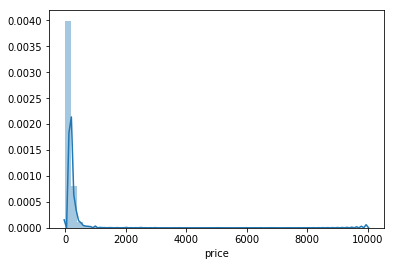

In [11]:
#What is the distribution of Y?

sb.distplot(train.price)

This is extremely right skewed, and also seems to contain some extreme outliers.

In [12]:
train.price.describe()

count    34204.000000
mean       152.362092
std        242.703030
min          0.000000
25%         69.000000
50%        108.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [13]:
#What is the correlation between then numerical values and price?
num=train.select_dtypes(exclude='object')
num.corr().price.to_frame().sort_values(by='price', ascending=False)

,price
price,1.000000
availability_365,0.083595
minimum_nights,0.062437
calculated_host_listings_count,0.060958
latitude,0.027270
host_id,0.007143
number_of_reviews,-0.047684
reviews_per_month,-0.049506
longitude,-0.151998


There are extremely weak correlations between many of the numerical values and the final price.

In [14]:
#What is the relationship between the categorical features and price?
train[['room_type','price']].groupby('room_type').median().sort_values(by='price', ascending=False)

,price
room_type,
Entire home/apt,160
Private room,70
Shared room,45


Not surprising that entire home/apt's are higher priced.

In [15]:
train[['neighbourhood_group','price']].groupby('neighbourhood_group').median().sort_values(by='price', ascending=False)

,price
neighbourhood_group,
Manhattan,150
Brooklyn,92
Staten Island,75
Queens,74
Bronx,65


Not surprising that Manhattan and Brooklyn are the most expensive.

In [16]:
neigh_counts = train.neighbourhood.value_counts().to_frame()
neigh_counts

,neighbourhood
Williamsburg,2767
Bedford-Stuyvesant,2595
Harlem,1840
Bushwick,1712
Upper West Side,1376
Hell's Kitchen,1364
East Village,1292
Upper East Side,1245
Crown Heights,1069
Midtown,1058


There are some extremely rare neighborhoods - these will probably be unimformative, won't help with our predictions, and increase the dimensionality of our data. Let's reclassify rare neighborhoods into 'other.'

In [17]:
def recat_val(data, col, num):
    data.loc[data[col].value_counts()[data[col]].values < num, col] = "Other"
    return data

In [18]:
train = recat_val(train, 'neighbourhood', 5)

In [19]:
train.neighbourhood.nunique()

188

In [20]:
train[['neighbourhood','price']].groupby('neighbourhood').mean().sort_values(by='price', ascending=False).head(10)

,price
neighbourhood,
Sea Gate,753.000000
Tribeca,509.948276
Riverdale,481.400000
Battery Park City,433.285714
Randall Manor,426.928571
Bay Terrace,333.500000
Flatiron District,304.885246
NoHo,295.192982
Greenwich Village,279.740602


There is definitely a relationship between neighbourhood and price - but this could definitely be due to the Manhattan, Brooklyn factor. It's interesting to note that Tribeca is nearly $200 more, on average, than Flatiron, Noho, Midtown. Neighborhood will most likely play an important role.

In [21]:
train

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews,reviews_per_month,price
23740,Beautiful Clinton Hill with huge private backyard,5992129,Beautiful Clinton Hill with huge private backyard,Brooklyn,Clinton Hill,40.68746,-73.96115,Entire home/apt,5,1,43,7,0.36,150
24296,Garden duplex in classic brownstone,16752839,Garden duplex in classic brownstone,Brooklyn,Carroll Gardens,40.68385,-73.99278,Entire home/apt,2,1,0,14,0.62,225
45754,Amazing Brooklyn 1Bd with Private Balcony,12061757,Amazing Brooklyn 1Bd with Private Balcony,Brooklyn,Brownsville,40.67511,-73.90836,Entire home/apt,2,1,71,3,3.00,100
12839,NEW SUNNY PEACEFUL ROOM in Prime Williamsburg,8119817,NEW SUNNY PEACEFUL ROOM in Prime Williamsburg,Brooklyn,Williamsburg,40.71821,-73.94116,Private room,2,2,127,0,0.00,115
9811,New 2BR+1BA For Up To 6 Ppl Only 15 Min To NYCity,347642,New 2BR+1BA For Up To 6 Ppl Only 15 Min To NYCity,Brooklyn,Bedford-Stuyvesant,40.68022,-73.92795,Entire home/apt,3,3,218,121,2.60,100
6996,Perfect Times Square 1 bedroom,22305520,Perfect Times Square 1 bedroom,Manhattan,Hell's Kitchen,40.76064,-73.99112,Entire home/apt,30,2,192,119,2.17,199
27316,Комната. Место в комнате,32168079,Комната. Место в комнате,Brooklyn,Sheepshead Bay,40.58612,-73.95014,Private room,30,3,170,0,0.00,50
7923,Central Williamsburg Room,909577,Central Williamsburg Room,Brooklyn,Williamsburg,40.71400,-73.96253,Private room,2,3,324,168,3.23,71
18905,Beautiful Bedroom by Prospect Park,97441717,Beautiful Bedroom by Prospect Park,Brooklyn,Flatbush,40.65228,-73.96402,Private room,3,1,0,1,0.03,65
12681,Cozy Room in Hell's Kitchen,25153542,Cozy Room in Hell's Kitchen,Manhattan,Hell's Kitchen,40.76057,-73.99038,Private room,1,1,0,1,0.02,85


Does the name play a role into the price? A hypothesis could be certain words could attract individuals to book. Let's do some simple text mining and create the name as a feature.

In [26]:
train['name_clean'] = train.name.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train['name_clean'] = train.name_clean.str.lower()

In [27]:
#Let's create a list of certain words that could play a factor in price that is independent from the room type.
words = ['spacious','luxury',
         'large','backyard',
         'beautiful','stylish',
         'amazing','convenient',
         'sunny','big','cozy']

In [28]:
def contains_word(data, col, word):
    data[word] = np.where(data[col].str.contains(word) == True, 1, 0)
    return data

In [29]:
for word in words:
    train = contains_word(train, 'name_clean', word)

In [30]:
###Process the data for modeling.

def process_data(data):
    data = data.drop(['name','host_id','host_name','latitude','longitude','name_clean'],axis=1)
    cat=data.select_dtypes(include='object')
    data = data.drop(cat.columns, axis=1)
    dummied_cat = pd.get_dummies(cat)
    data = pd.concat([data, dummied_cat], axis=1)
    y = train.price.values
    X = train.drop(['price'],axis=1).values
    
    return X, y

SyntaxError: invalid syntax (<ipython-input-30-ef02f2491adb>, line 5)

In [56]:
y_train = train.price.values
X_train = train.drop(['price'],axis=1).values

### Modeling

In [72]:
### Because y is so skewed, we need to log transform it to be able to use MSE.
from numpy import errstate,isneginf,array
y_train_log = np.log(y_train)
y_train_log[isneginf(y_train_log)]=0

/Users/jamesfung/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


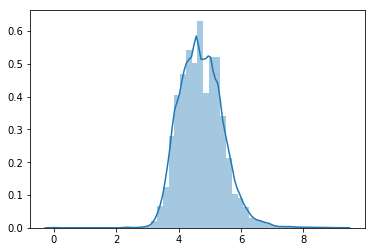

In [73]:
sb.distplot(y_train_log)

In [74]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm

In [75]:
from sklearn.linear_model import LinearRegression

lreg=LinearRegression()
MSEs=ms.cross_val_score(lreg, X_train, y_train_log, scoring='neg_mean_squared_error', cv=5)
meanMSE=np.mean(MSEs)
print(meanMSE)
print('RMSE = '+str(math.sqrt(-meanMSE)))

-0.225752373142
RMSE = 0.4751340580740516


In [76]:
import sklearn.model_selection as GridSearchCV
from sklearn.linear_model import Ridge

ridge=Ridge()
parameters= {'alpha':[x for x in range(1,101)]}

ridge_reg=ms.GridSearchCV(ridge, param_grid=parameters, scoring='neg_mean_squared_error', cv=15)
ridge_reg.fit(X_train,y_train)
print("The best value of Alpha is: ",ridge_reg.best_params_)
print("The best score achieved with Alpha=11 is: ",math.sqrt(-ridge_reg.best_score_))
ridge_pred=math.sqrt(-ridge_reg.best_score_)

The best value of Alpha is:  {'alpha': 31}
The best score achieved with Alpha=11 is:  229.00013167231188


In [77]:
ridge_mod=Ridge(alpha=15)
ridge_mod.fit(X_train,y_train)
y_pred_train=ridge_mod.predict(X_train)
y_pred_test=ridge_mod.predict(x_test)

print('Root Mean Square Error train = ' + str(math.sqrt(sklm.mean_squared_error(y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test, y_pred_test))))   

NameError: name 'x_train' is not defined